In [1]:
import pickle
import os
from glob import glob
import datetime
from matplotlib.backend_bases import register_backend
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import numpy as np
import seaborn as sns

# switch to pgf backend -- it is better at producing small pdf files
from matplotlib.backends.backend_pgf import FigureCanvasPgf

register_backend("pdf", FigureCanvasPgf)

# add the correct path to latex into PATH. This depends on the system!
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"

# pretty inline display
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# use a more modern style for plots
plt.style.use(style="ggplot")

plt.rcParams.update(
    {
        # Use 9pt font in plots, to match 9pt font in document
        "axes.labelsize": 9,
        "font.size": 9,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "font.family": "serif",
        # TeX setup for inline backend
        "text.usetex": True,
        "text.latex.preamble": r"""
            \usepackage{libertine}
            \usepackage[libertine]{newtxmath}""",
        # TeX setup for pdf backend
        "pgf.rcfonts": False,  # don't setup fonts from rc parameters
        "pgf.texsystem": "pdflatex",
        "pgf.preamble": r"""
            \usepackage{libertine}
            \usepackage[libertine]{newtxmath}""",
    }
)

# widths of figures in inches
TWO_COLUMN_FIG_WIDTH = 7.0056
SINGLE_COLUMN_FIG_WIDTH = 3.337

# Experiment 5R

Let's read in the files:

In [2]:
output_dir = "./experiments/experiment5R/experiment5R_output"
file_pattern = "experiment5_results_*.pickle"

results = []

for file_path in glob(os.path.join(output_dir, file_pattern)):
    with open(file_path, "rb") as f:
        run_results = pickle.load(f)
        results.extend(run_results)

Check that we have all the results:

In [3]:
len(results)

3584

In [4]:
run_ids = tuple(res["run_id"] for res in results)
for i in range(896):
    if i not in run_ids:
        print(i)

We've got all runs now!

Each result contains the following pieces of information:

In [5]:
list(results[0].keys())

['run_id',
 'duration',
 'run_length',
 'time_until_surpass',
 'exploration_coef',
 'attack_reward',
 'action_dist_0',
 'params',
 'agent_df',
 'lower_tree_query_data',
 'actions',
 'rewards',
 'action_qualities']

Preview the action quality estimate results:

In [6]:
results[0]["action_qualities"]

,time,estimator,actor,qualities,n_expansions
0,0,0,0,"[-0.0021838732023091224, -0.10717841088752929,...","[4562, 183, 182]"
1,0,0,1,"[-0.19248144931455002, -0.20127410191045414, -...",None
2,0,1,1,"[-0.29130395512430085, -0.24513749582466546, -...","[478, 2189, 2300]"
3,0,1,0,"[-0.00224312160109426, -0.08877311996427868, -...",None


Display statistics on the durations of runs:

In [7]:
subset = [res["duration"] for res in results]
avg_duration = sum((d for d in subset), start=datetime.timedelta(0)) / len(subset)
print(f"Average: {avg_duration}")
print(f"Maximum: {max(subset)}")

Average: 0:02:28.536855
Maximum: 0:05:40.263998


In [8]:
# average time for reasoning level 1
subset = [res["duration"] for res in results if res["params"]["reasoning_level"] == 1]
avg_duration = sum((d for d in subset), start=datetime.timedelta(0)) / len(subset)
print(f"Average: {avg_duration}")
print(f"Maximum: {max(subset)}")

Average: 0:03:23.267178
Maximum: 0:05:40.263998


Let's check the lower-level model query success rate:

In [9]:
avg_rates_strong = np.array([0, 0, 0, 0], dtype=np.float_)
avg_rates_weak = np.array([0, 0, 0, 0], dtype=np.float_)
n = 0
for res in results:
    if res["params"]["reasoning_level"] == 0:
        continue

    res_rates_strong = res["lower_tree_query_data"]["Civ 0,"][1:]
    res_rates_weak = res["lower_tree_query_data"]["Civ 1,"][1:]

    assert round(sum(res_rates_strong), 3) == 1
    assert round(sum(res_rates_weak), 3) == 1

    avg_rates_strong += res_rates_strong
    avg_rates_weak += res_rates_weak
    n += 1

avg_rates_strong = avg_rates_strong / n
avg_rates_weak = avg_rates_weak / n
print(f"Weak {avg_rates_weak.round(2)}, strong {avg_rates_strong.round(2)}")

Weak [0.97 0.   0.   0.03], strong [0.94 0.   0.01 0.05]


Let's create a dataframe of the chosen action in each run:

In [10]:
rows = []

for run_result in results:
    attack_reward = run_result["attack_reward"]
    reasoning_level = run_result["params"]["reasoning_level"]
    exploration_coef = run_result["exploration_coef"]
    action_dist_0 = run_result["action_dist_0"]
    time_until_surpass = run_result["params"]["initial_belief_params"][
        "time_until_surpass"
    ]
    prob_surpass_0 = run_result["params"]["initial_belief_params"]["prob_surpass_0"]
    prob_surpass_1 = run_result["params"]["initial_belief_params"]["prob_surpass_1"]

    run_action_qualities = run_result["action_qualities"]

    for actor in (0, 1):
        # determine the action of the actor
        actor_action_qualities = run_action_qualities[
            (run_action_qualities["estimator"] == actor)
            & (run_action_qualities["actor"] == actor)
        ].iloc[0]["qualities"]

        # find the action with the highest quality
        best_action = [
            q_i
            for q_i, q in enumerate(actor_action_qualities)
            if q == max(actor_action_qualities)
        ]
        assert len(best_action) == 1
        best_action = best_action[0]

        # add row
        rows.append(
            (
                attack_reward,
                reasoning_level,
                time_until_surpass,
                prob_surpass_0,
                prob_surpass_1,
                actor,
                exploration_coef,
                action_dist_0,
                best_action,
            )
        )

action_data = pd.DataFrame(
    rows,
    columns=(
        "attack_reward",
        "reasoning_level",
        "time_until_surpass",
        "prob_surpass_0",
        "prob_surpass_1",
        "actor",
        "exploration_coef",
        "action_dist_0",
        "action",
    ),
)

In [11]:
action_data

,attack_reward,reasoning_level,time_until_surpass,prob_surpass_0,prob_surpass_1,actor,exploration_coef,action_dist_0,action
0,0.0,1,2,0.320147,0.405529,0,0.6,random,0
1,0.0,1,2,0.320147,0.405529,1,0.6,random,1
2,-0.1,1,2,0.320147,0.405529,0,0.6,random,2
3,-0.1,1,2,0.320147,0.405529,1,0.6,random,2
4,0.0,1,4,0.320147,0.405529,0,0.6,random,0
...,...,...,...,...,...,...,...,...,...
7163,-0.1,1,2,0.072726,0.080237,1,0.6,random,2
7164,0.0,1,4,0.072726,0.080237,0,0.6,random,0
7165,0.0,1,4,0.072726,0.080237,1,0.6,random,0
7166,-0.1,1,4,0.072726,0.080237,0,0.6,random,2


Let's first visualise the experiment in reasoning level 0 ('experiment 5A').

In [12]:
data_5A = action_data[(action_data["reasoning_level"] == 0)].copy()

# create bins for prob_surpass_0
prob_bins = np.linspace(0, 1, 21)
data_5A["prob_surpass_0_bin"] = pd.cut(x=data_5A["prob_surpass_0"], bins=prob_bins)

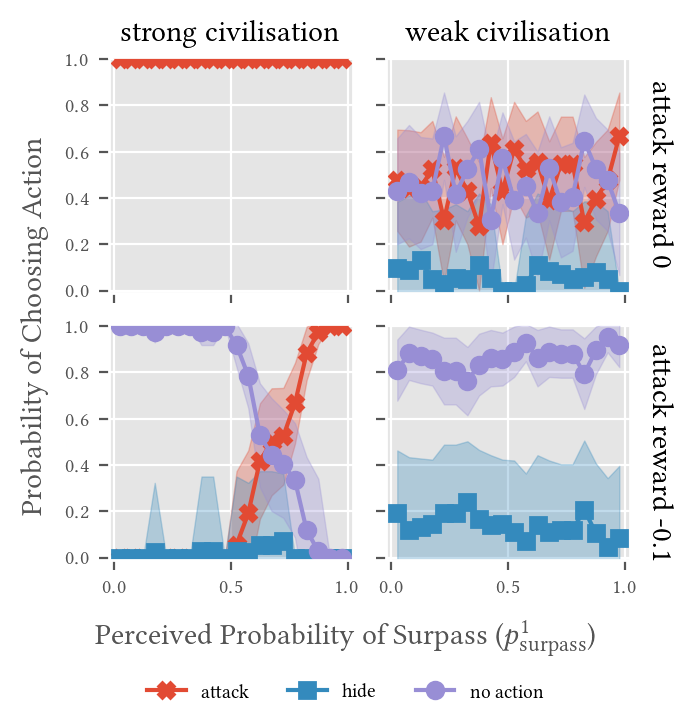

In [13]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(SINGLE_COLUMN_FIG_WIDTH, 3.5),
    constrained_layout=True,
    sharey=True,
    sharex=True,
)

# adjust the rectangle in which constrained layout lays out the figure
bottom_margin = 0.15
right_margin = 0.05
# (left, bottom, width height)
fig.get_layout_engine().set(
    rect=(0, bottom_margin, 1 - right_margin, 1 - bottom_margin)
)

action_names = {0: "attack", 1: "hide", 2: "no action"}
action_symbols = {0: "X", 1: "s", 2: "o"}
agent_names = {0: "strong civilisation", 1: "weak civilisation"}


for plot_column, actor in enumerate((0, 1)):
    for plot_row, attack_reward in enumerate((0, -0.1)):
        # plot on the desired axes
        ax = axs[plot_row, plot_column]

        # find correct subset of data
        subset = data_5A[
            (data_5A["actor"] == actor) & (data_5A["attack_reward"] == attack_reward)
        ]

        # calculate proportions within each bin
        action_proportions = subset.groupby("prob_surpass_0_bin")[
            "action"
        ].value_counts(normalize=True)
        action_counts = subset.groupby("prob_surpass_0_bin")["action"].value_counts()
        proportion_error_margins = 1.96 * np.sqrt(
            action_proportions * (1 - action_proportions) / action_counts
        )
        action_proportions = action_proportions.unstack(level=1, fill_value=0)
        proportion_error_margins = proportion_error_margins.unstack(
            level=1, fill_value=0
        )
        action_proportions.index = pd.IntervalIndex(
            action_proportions.index, name="attack_reward_bin_mid"
        ).mid
        proportion_error_margins.index = pd.IntervalIndex(
            proportion_error_margins.index, name="attack_reward_bin_mid"
        ).mid

        # plot
        for action in action_proportions.columns:
            proportions = action_proportions[action]
            error_margin = proportion_error_margins[action]
            ax.plot(
                proportions.index,
                proportions,
                label=action_names[action],
                color=f"C{action}",
                marker=action_symbols[action],
            )
            ax.fill_between(
                proportions.index,
                proportions + error_margin,
                proportions - error_margin,
                alpha=0.3,
                color=f"C{action}",
            )

        if plot_row == 0:
            ax.set_title(agent_names[actor], fontsize="large")
        ax.set_ylim(-0.01, 1.01)


fig.supxlabel(
    r"Perceived Probability of Surpass ($p_{\mathrm{surpass}}^1$)",
    color=plt.rcParams["xtick.color"],
    y=0.08,
)
fig.supylabel(
    "Probability of Choosing Action", color=plt.rcParams["xtick.color"], y=0.55
)

legend_handles = [
    mlines.Line2D(
        [],
        [],
        color=f"C{action}",
        marker=action_symbols[action],
        label=action_names[action],
    )
    for action in (0, 1, 2)
]

fig.legend(
    handles=legend_handles,
    bbox_to_anchor=(0.5, 0),
    loc="lower center",
    frameon=False,
    ncols=3,
    borderpad=0,
)

fig.text(x=0.95, y=0.64, s="attack reward 0", rotation=-90, fontsize="large")
fig.text(x=0.95, y=0.22, s="attack reward -0.1", rotation=-90, fontsize="large")

# plt.savefig("paper/experiment5a.pdf")
plt.show()

Next, let's investigate the level 1 situation (experiment 5B):

In [14]:
data_5B = action_data[(action_data["reasoning_level"] == 1)].copy()

# create bins for prob_surpass_0 and prob_surpass_1
prob_bins = np.linspace(0, 1, 5)
data_5B["prob_surpass_0_bin"] = pd.cut(x=data_5B["prob_surpass_0"], bins=prob_bins)
data_5B["prob_surpass_1_bin"] = pd.cut(x=data_5B["prob_surpass_1"], bins=prob_bins)

data_5B

,attack_reward,reasoning_level,time_until_surpass,prob_surpass_0,prob_surpass_1,actor,exploration_coef,action_dist_0,action,prob_surpass_0_bin,prob_surpass_1_bin
0,0.0,1,2,0.320147,0.405529,0,0.6,random,0,"(0.25, 0.5]","(0.25, 0.5]"
1,0.0,1,2,0.320147,0.405529,1,0.6,random,1,"(0.25, 0.5]","(0.25, 0.5]"
2,-0.1,1,2,0.320147,0.405529,0,0.6,random,2,"(0.25, 0.5]","(0.25, 0.5]"
3,-0.1,1,2,0.320147,0.405529,1,0.6,random,2,"(0.25, 0.5]","(0.25, 0.5]"
4,0.0,1,4,0.320147,0.405529,0,0.6,random,0,"(0.25, 0.5]","(0.25, 0.5]"
...,...,...,...,...,...,...,...,...,...,...,...
7163,-0.1,1,2,0.072726,0.080237,1,0.6,random,2,"(0.0, 0.25]","(0.0, 0.25]"
7164,0.0,1,4,0.072726,0.080237,0,0.6,random,0,"(0.0, 0.25]","(0.0, 0.25]"
7165,0.0,1,4,0.072726,0.080237,1,0.6,random,0,"(0.0, 0.25]","(0.0, 0.25]"
7166,-0.1,1,4,0.072726,0.080237,0,0.6,random,2,"(0.0, 0.25]","(0.0, 0.25]"


('strong civ. (attack)', 0)
prob_surpass_1_bin  0.125  0.375  0.625  0.875
prob_surpass_0_bin                            
0.875                 0.0    0.0    0.0    0.0
0.625                 0.0    0.0    0.0    0.0
0.375                 0.0    0.0    0.0    0.0
0.125                 0.0    0.0    0.0    0.0
('strong civ. (attack)', -0.1)
prob_surpass_1_bin  0.125  0.375  0.625  0.875
prob_surpass_0_bin                            
0.875                 NaN    NaN    NaN    NaN
0.625                 NaN    NaN    NaN    NaN
0.375                 NaN    NaN    NaN    NaN
0.125                 NaN    NaN    NaN    NaN
('weak civ. (hide)', 0)
prob_surpass_1_bin     0.125     0.375     0.625     0.875
prob_surpass_0_bin                                        
0.875               0.162052  0.170513  0.178573  0.203143
0.625               0.153125  0.143644  0.146872  0.186285
0.375               0.173241  0.173241  0.175927  0.186285
0.125               0.214375  0.214375  0.205439  0.222953

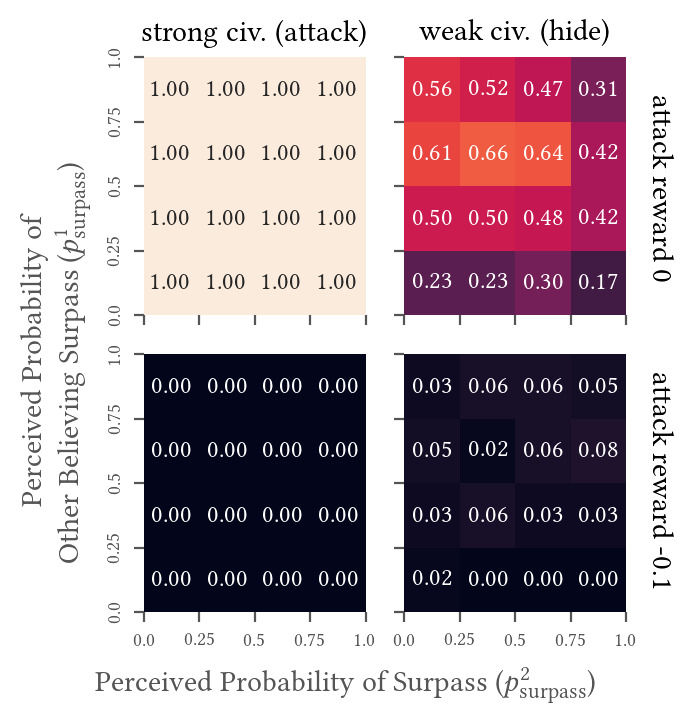

In [15]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(SINGLE_COLUMN_FIG_WIDTH, 3.5),
    constrained_layout=True,
    sharex=True,
    sharey=True,
)

# adjust the rectangle in which constrained layout lays out the figure
bottom_margin = 0
right_margin = 0.05
# (left, bottom, width height)
fig.get_layout_engine().set(
    rect=(0, bottom_margin, 1 - right_margin, 1 - bottom_margin)
)

action_names = {0: "attack", 1: "hide", 2: "no action"}
agent_names = {0: "strong civ. (attack)", 1: "weak civ. (hide)"}

actor_display_action = {0: 0, 1: 1}

for plot_column, actor in enumerate((0, 1)):
    for plot_row, attack_reward in enumerate((0, -0.1)):
        action = actor_display_action[actor]

        # plot on the desired axes
        ax = axs[plot_row, plot_column]

        # find correct subset of data
        subset = data_5B[
            (data_5B["actor"] == actor) & (data_5B["attack_reward"] == attack_reward)
        ]

        # calculate proportions within each bin
        action_proportions = subset.groupby(
            ["prob_surpass_0_bin", "prob_surpass_1_bin"]
        )["action"].value_counts(normalize=True)
        action_proportions = action_proportions.unstack(level=2, fill_value=0)
        action_proportions = action_proportions.reset_index()
        action_proportions["prob_surpass_0_bin"] = np.round(
            pd.IntervalIndex(action_proportions["prob_surpass_0_bin"]).mid, 3
        )
        action_proportions["prob_surpass_1_bin"] = np.round(
            pd.IntervalIndex(action_proportions["prob_surpass_1_bin"]).mid, 3
        )

        action_counts = subset.groupby(["prob_surpass_0_bin", "prob_surpass_1_bin"])[
            "action"
        ].value_counts()
        action_counts = action_counts.unstack(level=2, fill_value=0)
        action_counts = action_counts.reset_index()
        action_counts["prob_surpass_0_bin"] = np.round(
            pd.IntervalIndex(action_counts["prob_surpass_0_bin"]).mid, 3
        )
        action_counts["prob_surpass_1_bin"] = np.round(
            pd.IntervalIndex(action_counts["prob_surpass_1_bin"]).mid, 3
        )

        # make sure all actions are present
        if action not in action_proportions.columns:
            action_proportions[action] = 0

        if action not in action_counts.columns:
            action_counts[action] = 0

        # turn into rectangular fomrat
        action_proportions = action_proportions.pivot(
            index="prob_surpass_0_bin", columns="prob_surpass_1_bin", values=action
        )

        action_counts = action_counts.pivot(
            index="prob_surpass_0_bin", columns="prob_surpass_1_bin", values=action
        )

        # reverse rows
        action_proportions = action_proportions.iloc[::-1]
        action_counts = action_counts.iloc[::-1]

        # calculate error margin
        proportion_error_margins = 1.96 * np.sqrt(
            action_proportions * (1 - action_proportions) / action_counts
        )
        print((agent_names[actor], attack_reward))
        print(proportion_error_margins)

        # plot heat map
        map = sns.heatmap(
            action_proportions, ax=ax, vmin=0, vmax=1, annot=True, cbar=False, fmt=".2f"
        )

        if plot_row == 0:
            ax.set_title(agent_names[actor], fontsize="large")

        ax.set_xlabel("")
        ax.set_ylabel("")

        # add ticks in the correct places (before and after each cell)
        # they need to be reversed for the vertical axis because it is already reversed
        ax.set_xticks(np.arange(len(prob_bins)), prob_bins)
        ax.set_yticks(np.arange(len(prob_bins)), prob_bins[::-1])

fig.supxlabel(
    r"Perceived Probability of Surpass ($p_{\mathrm{surpass}}^2$)",
    color=plt.rcParams["xtick.color"],
)
fig.supylabel(
    r"Perceived Probability of"
    + "\n"
    + "Other Believing Surpass ($p_{\mathrm{surpass}}^1$)",
    color=plt.rcParams["xtick.color"],
    ma="center",
)
fig.text(x=0.95, y=0.62, s="attack reward 0", rotation=-90, fontsize="large")
fig.text(x=0.95, y=0.18, s="attack reward -0.1", rotation=-90, fontsize="large")

# plt.savefig("paper/experiment5b.pdf")
plt.show()